# Can you predict the Tide?

## Goal

Participants will have to forecast the sea surges in two western European coastal cities.

We place ourselves in a forecast setup: knowing the surge values and the sea-level pressure field in the last 5 days, we want to predict the surge values in the next five days. It is hence a time series prediction problem. The signals we consider are:

- the surge, which is a function of the time.
- the sea-level pressure, which is a function of the time, the latitude and the longitude.

The score $l(\hat{y},y)$ we use to measure the quality of the prediction $\hat{y}$​ compared to the true values $y$ is a weighted version of the mean square error (MSE). The weights depend linearly on the forecast time, with a bigger weight for the first forecast time and a lower weight for the last forecast time. The prediction for the two cities are computed independently, and the final loss is their sum:

```python
def surge_prediction_metric(y_true, y_pred):
    w = np.linspace(1, 0.1, 10)[np.newaxis]
    surge1_cols = [
        'surge1_t0', 'surge1_t1', 'surge1_t2', 'surge1_t3', 'surge1_t4',
        'surge1_t5', 'surge1_t6', 'surge1_t7', 'surge1_t8', 'surge1_t9' ]
    surge2_cols = [
        'surge2_t0', 'surge2_t1', 'surge2_t2', 'surge2_t3', 'surge2_t4',
        'surge2_t5', 'surge2_t6', 'surge2_t7', 'surge2_t8', 'surge2_t9' ]
    surge1_score = (w * (y_true[surge1_cols].values - y_pred[surge1_cols].values)**2).mean()
    surge2_score = (w * (y_true[surge2_cols].values - y_pred[surge2_cols].values)**2).mean()

    return surge1_score + surge2_score
```


Since the surge values are normalized (zero mean and standard deviation 1), $1-l$ can be seen as a percentage of explained variance. With a trivial zero prediction of all values, the score is $l \approx 1$ , meaning that we explain 0 % of the variance. A score bigger than one is hence worse that the zero prediction and can be considered as "bad".

## Data description

The training set contains 5599 entries, and the test set contains 509 entries. Each entry represents approximately 5 days of measurements of the pressure and the tide, and the times at which they were done.

**Times** are given in the GMT convention. In the GMT convention, the time is expressed as the number of seconds elapsed since January 1st, 1970; they can be converted to the usual Gregorian time with `time.gmtime()`. Note that in our dataset, some times are negative: indeed, the first measurements date back to the 1950s. For instance, the very first sea-level pressure field is given at $t=−631108800.0$ which corresponds to 1950, January 1st at approximately 21h.

**Sea-Level** Pressure fields (SLP) are given every three hours, so there are 40 fields for every observation. They cover the Atlantic front of western Europe and Iceland, as shown on the following map:

![SLP map](images/slp.png)

Sea surges are measured for each high tide, i.e. every 12 hours approximately. We measure the sea surge at two different locations, which are two anonymous European costal cities. Consequently, each entry contains `2×102×10` values to predict. There are in total $20×509=10180$ values to predict for the test. Note that the surge values in cities 1 and 2 have been normalized, such that they have 0 mean and standard deviation 1. The true means and std of the surge are of the order of 10cm and 20cm respectively.

The **.npz format**: practically, the input X is encoded in the numpy .npz format and consists of:

- id_sequence: the ids of the sequence
- t_slp: the 40 GMT times at which the sea-level pressure (SLP) fields are given.
- slp: the 40 sea-level pressure (SLP) fields, encoded in images of size (41, 41).
- t_surge1_input: the 10 GMT times at which the surge heights are given in city 1.
- surge1_input: the given surge heights in city 1.
- t_surge2_input: the 10 GMT times at which the surge heights are given in city 2.
- surge2_input: the given surge heights in city 2.
- t_surge1_output: the 10 GMT times at which we must predict surge heights in city 1.
- t_surge2_output: the 10 GMT times at which we must predict surge heights in city 2.

To access for example the training slp, one can use the following:

```python
X_train = np.load('X_train_surge.npz')
slp = X_train['slp']
```

The output Y is encoded in a csv file with the columns:


- id_sequence: the ids of the sequence
- surge1_t{0...9}: the correct surge height in city 1 at time 0 to 9
- surge2_t{0...9}: the correct surge height in city 2 at time 0 to 9

**Submission format** We provided a random submission example. The submission index must be X_test['id_sequence'] and the columns must match those of Y_train_surge.csv: see the notebook in the supplementary files for another submission example. 

## Benchmark description

Analog methods in meteorology are the equivalent of nearest-neighbors predictions in machine learning. It consists in finding a day in the past when the weather scenario looked very similar to the actual weather scenario (an analog scenario). The forecaster would predict that the weather in this forecast will behave the same as it did in the past. Physicists appreciate these methods for their interpretability, as the prediction is explained by a real past situation that they can look at. They can also a posteriori analyze the prediction errors given the difference between the actual scenario and the analog found in the past.

The benchmark we propose here is an analog method. We use the standard L2 metric and look for the closest k=40k=40 scenarios at time t and t - 24h using a K-nearest neighbor search. We then average over these scenarios to get the benchmark. It yields a score of 0.77 on the public test data, meaning that it explained around 23 % of the variance.

We provide in the supplementary files a Jupyter Notebook that implements this benchmark.

## Answer

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf

2023-02-06 23:16:50.029210: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-06 23:16:50.181093: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-06 23:16:50.181120: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-02-06 23:16:50.815891: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [2]:
X_train = np.load(os.path.join('assets', 'X_train_surge_new.npz'))
Y_train = pd.read_csv(os.path.join('assets', 'Y_train_surge.csv'))
X_test = np.load(os.path.join('assets', 'X_test_surge_new.npz'))

In [ ]:
# create a gif of all 40 images of the first sample
# from https://stackoverflow.com/a/56244531/1164295
def create_gif(images, filename, duration=0.1):
  import imageio
  images = [imageio.imread(image) for image in images]
  imageio.mimsave(filename, images, duration=duration)


# try create assets/images folder
try:
  os.mkdir('assets/images')
except FileExistsError:
  pass

if not os.path.exists(os.path.join('assets', 'images', 'surge_sample.gif')):

  images = []
  for i in range(40):
    data = X_train['slp'][0, i, :, :]
    plt.imsave(os.path.join('assets', 'images', f'surge_sample_{i}.png'), data, cmap='jet')
    images.append(os.path.join('assets', 'images', f'surge_sample_{i}.png'))

  create_gif(images, os.path.join('assets', 'images', f'surge_sample.gif'), duration=0.1)

In [1]:
# display the gif
from IPython.display import Image
Image(url=os.path.join('assets', 'images', f'surge_sample.gif'), width=500)

In [3]:
x_surge1 = X_train['surge1_input']  # (5599, 10)
x_surge2 = X_train['surge2_input']  # (5599, 10)

x_surge1_times = X_train['t_surge1_input']  # (5599, 10)
x_surge2_times = X_train['t_surge2_input']  # (5599, 10)

x_surge_ids = X_train['id_sequence']

# x_slp = X_train['slp']       # (5599, 40, 41, 41)
# x_slp = x_slp[:, ::4, :, :]  # (5599, 10, 41, 41)

y_surge1 = np.array([Y_train[f'surge1_t{i}'] for i in range(10)]).T  # (5599, 10)
y_surge2 = np.array([Y_train[f'surge2_t{i}'] for i in range(10)]).T  # (5599, 10)

y_surge_ids = Y_train['id_sequence'].values

y_surge1_expected_times = X_train['t_surge1_output']
y_surge2_expected_times = X_train['t_surge2_output']

print(x_surge1.shape, y_surge1.shape)
print(x_surge_ids, y_surge_ids)

(5599, 10) (5599, 10)
[   1    2    3 ... 5597 5598 5599] [   1    2    3 ... 5597 5598 5599]


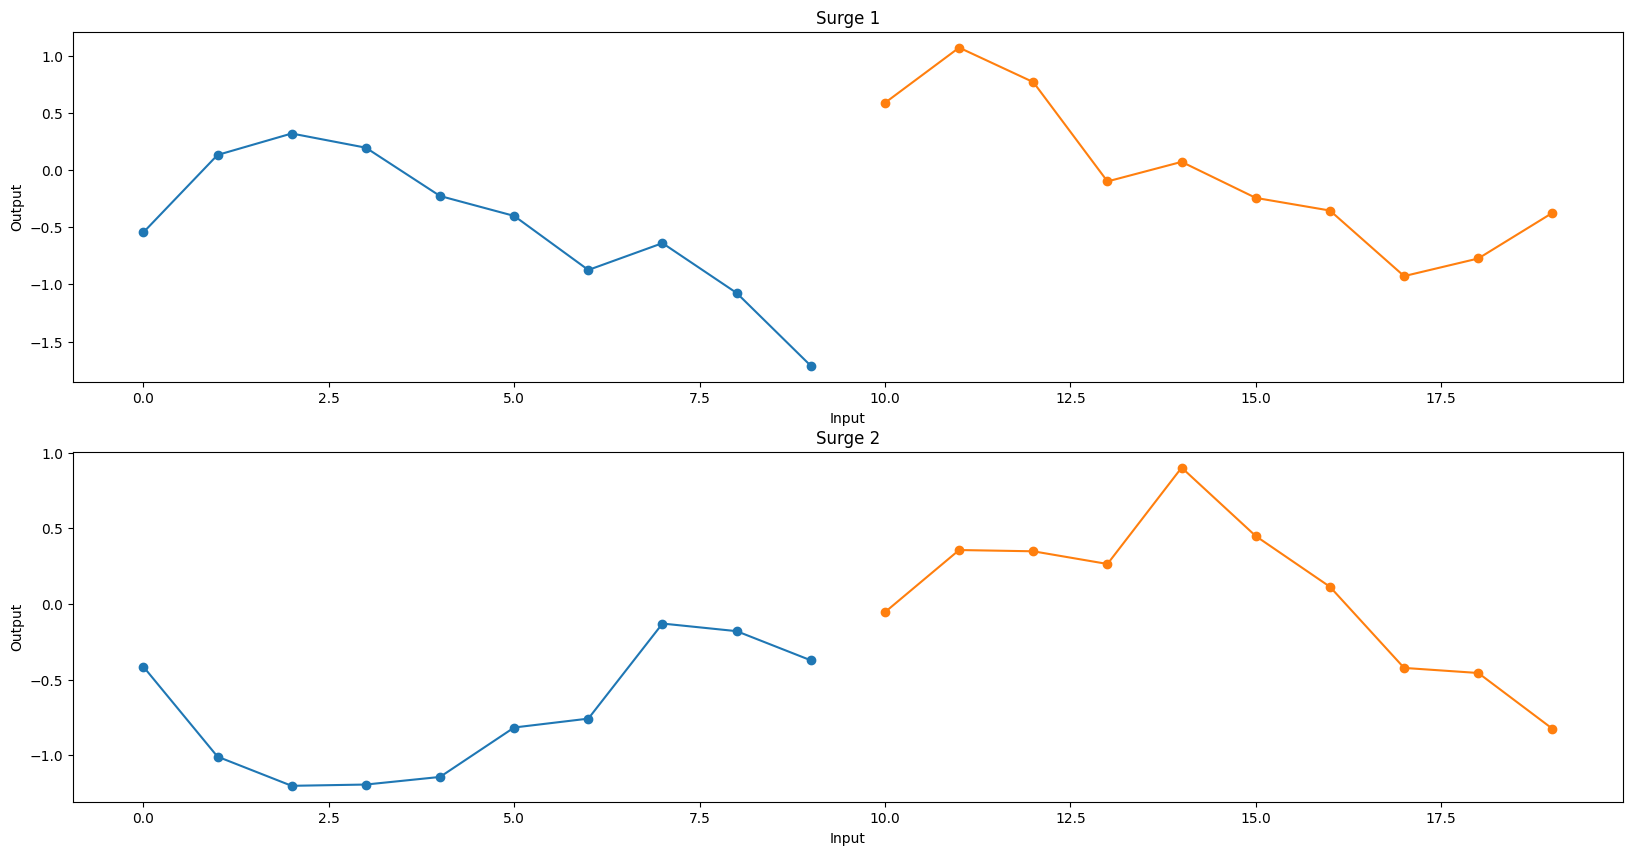

In [4]:
idx = 0

# display (x_surge1, y_surge1) and (x_surge2, y_surge2) in a single plot
fig, ax = plt.subplots(2, 1, figsize=(20, 10))
ax[0].plot(range(10), x_surge1[idx], 'o-')
ax[0].plot(range(10, 20), y_surge1[idx], 'o-')
ax[0].set_title('Surge 1')
ax[0].set_xlabel('Input')
ax[0].set_ylabel('Output')
ax[1].plot(range(10), x_surge2[idx], 'o-')
ax[1].plot(range(10, 20), y_surge2[idx], 'o-')
ax[1].set_title('Surge 2')
ax[1].set_xlabel('Input')
ax[1].set_ylabel('Output')
plt.show()


In [ ]:
# create input and output data
X = []
Y = []

for (x1, x2, y1, y2) in zip(x_surge1, x_surge2, y_surge1, y_surge2):
  X.append(x1)
  X.append(x2)
  Y.append(y1)
  Y.append(y2)

# create train and test data
X_train, X_test = np.array(X[:10000]), np.array(X[10000:])
Y_train, Y_test = np.array(Y[:10000]), np.array(Y[10000:])

print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

In [ ]:
# model = tf.keras.Sequential([
#   tf.keras.layers.Dense(128, activation='relu', input_shape=(10,)),
#   tf.keras.layers.Dense(128, activation='relu'),
#   tf.keras.layers.Dense(128, activation='relu'),
#   tf.keras.layers.Dense(10)
# ])
# model.compile(loss='mse', optimizer='adam', metrics=['mae'])

model = tf.keras.Sequential([
  tf.keras.layers.LSTM(128, return_sequences=True, input_shape=(10, 1)),
  tf.keras.layers.LSTM(128),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(10)
])

model.compile(loss='mse', optimizer='adam', metrics=['mae', 'mse'])

In [ ]:
# fit model
history = model.fit(X_train, Y_train, epochs=100, batch_size=32, validation_data=(X_test, Y_test))

# plot loss
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [ ]:
# make predictions
Y_pred = model.predict(X_test)

score = model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', score)
 
# plot predictions
fig, ax = plt.subplots(4, 5, figsize=(20, 10))
for i in range(4):
  for j in range(5):
    idx = i * 5 + j
    ax[i, j].plot(range(10), X_test[idx], 'o-')
    ax[i, j].plot(range(10, 20), Y_test[idx], 'o-')
    ax[i, j].plot(range(10, 20), Y_pred[idx], 'o-')
    ax[i, j].set_title(f'Prediction {idx}')
    ax[i, j].set_xlabel('Time')
    ax[i, j].set_ylabel('Surge')
plt.show()  # predictions are not good

In [ ]:
import surge_prediction_metric as surge

# convert predictions to dataframe
Y_pred_df = pd.DataFrame(Y_pred, columns=[f'surge{j}_t{i}' for i in range(10) for j in range(1, 3)])
Y_true_df = pd.DataFrame(Y_test, columns=[f'surge{j}_t{i}' for i in range(10) for j in range(1, 3)])

Y_pred_df = Y_pred_df.loc[Y_true_df.index]

s1 = surge.surge_prediction_metric(Y_true_df[:10], Y_pred_df[:10])
s2 = surge.surge_prediction_metric(Y_true_df[10:], Y_pred_df[10:])
print(s1, s2)